In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from Utils import *
from IPython.display import display

# Loading data

In [2]:
train_stratified_directory = 'GroupedData/train.csv'
validation_directory = 'GroupedData/validation_random.csv'

In [3]:
train_stratified, train_stratified_label = load_shopping_data(train_stratified_directory)
validation, validation_label = load_shopping_data(validation_directory)

# Training

## Support Vector Machine

In [4]:
clf = svm.SVC(kernel='rbf', decision_function_shape='ovr')
clf.fit(train_stratified, train_stratified_label)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [5]:
train_accuracy = clf.score(train_stratified, train_stratified_label)
testing_accuracy = clf.score(validation, validation_label)
print('Training accuracy =', train_accuracy)
print("Testing accuracy =", testing_accuracy)

Training accuracy = 0.850836699365
Testing accuracy = 0.1216


## Grid Search with CV  (Takes a very long time, do not run)

In [8]:
cv_train = np.vstack([train_stratified, validation])
cv_label = np.hstack([train_stratified_label, validation_label])

In [6]:
c_options = [0.01, 0.05, 0.1, 0.5 , 1, 10]
gamma_options = [1/5, 1/2, 1]
num_c = len(c_options)
num_gammas = len(gamma_options)
numer_of_cv = 5
search_result = np.zeros([num_c*num_gammas, numer_of_cv])

In [10]:
for i in range(num_c):
    for j in range(num_gammas):
        clf = svm.SVC(C = c_options[i], gamma=gamma_options[j], kernel='rbf', decision_function_shape='ovr')
        values = crossValidation(cv_train, cv_label, clf, numer_of_cv)
        values = np.ravel(values)
        search_result[num_gammas*i+j, :] = values
        print('Running on combo c=%0.2f, gamma=%0.2f, mean = %f' % 
              ( c_options[i], gamma_options[j], values.mean()))

Running on combo c=0.01, gamma=0.20, mean = 0.129402
Running on combo c=0.01, gamma=0.50, mean = 0.129400
Running on combo c=0.01, gamma=1.00, mean = 0.129399
Running on combo c=0.05, gamma=0.20, mean = 0.129400
Running on combo c=0.05, gamma=0.50, mean = 0.129402
Running on combo c=0.05, gamma=1.00, mean = 0.129398
Running on combo c=0.10, gamma=0.20, mean = 0.129399
Running on combo c=0.10, gamma=0.50, mean = 0.129401
Running on combo c=0.10, gamma=1.00, mean = 0.129401
Running on combo c=0.50, gamma=0.20, mean = 0.129400
Running on combo c=0.50, gamma=0.50, mean = 0.129399
Running on combo c=0.50, gamma=1.00, mean = 0.129400
Running on combo c=1.00, gamma=0.20, mean = 0.130035
Running on combo c=1.00, gamma=0.50, mean = 0.129770
Running on combo c=1.00, gamma=1.00, mean = 0.129506
Running on combo c=10.00, gamma=0.20, mean = 0.128499
Running on combo c=10.00, gamma=0.50, mean = 0.130195
Running on combo c=10.00, gamma=1.00, mean = 0.129613


In [14]:
opt = np.argmax(search_result.mean(axis = 1))
opt_c = c_options[int(np.floor(float(opt)/num_gammas))]
opt_gamma = gamma_options[opt % num_gammas]

print('The best result is obtained with C  = %0.2f, gamma = %0.2f, mean = %f, std = %f' % 
        (opt_c, opt_gamma, search_result[opt,:].mean(), search_result[opt,:].std()))

The best result is obtained with C  = 10.00, gamma = 0.50, mean = 0.130195, std = 0.003521


### Normal KFold Cross Validation

In [15]:
clf = svm.SVC(C = opt_c, gamma=opt_gamma, kernel='rbf', decision_function_shape='ovr')

In [16]:
cv_result = crossValidation(cv_train, cv_label, clf, cv=5)

In [ ]:
print("The result for each fold is \n", cv_result[:, 0])
print("The average result is %f, with standard deviation of %f" % (cv_result.mean(), cv_result.std()))

# Final Classifier

In [11]:
clf = svm.SVC(kernel='rbf', decision_function_shape='ovr', probability=True, C=opt_c, gamma=opt_gamma)
clf.fit(cv_train, cv_label)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [18]:
test_directory = 'GroupedData/test_random.csv'
test, test_label = load_shopping_data(test_directory)

In [19]:
testing_accuracy = clf.score(test, test_label)
train_accuracy = clf.score(cv_train, cv_label)
print('Training accuracy =', train_accuracy)
print("Testing accuracy =", testing_accuracy)

Training accuracy = 0.850836699365
Testing accuracy = 0.1292


## Micro ROC Curve

In [22]:
y_score = clf.decision_function(test)
lb = LabelBinarizer()
new_test_label = lb.fit(train_stratified_label).transform(test_label)
fpr, tpr = roc_curve(new_test_label.ravel(), y_score.ravel())

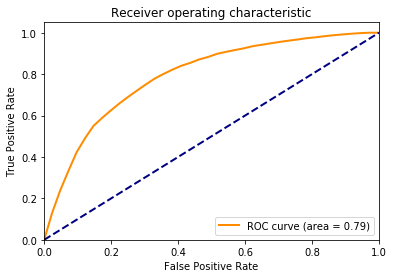

In [23]:
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()